# Cuaderno para realizar la exploracion en la busqueda de la homogeneizacion de las series

Partimos de utilizar los datos proporcionados por la pagina del [National Weather Service](http://www.nws.noaa.gov/) de los estados unidos, donde descargamos los datos del ONI(Oceanic Nino Index), de esta forma obtenemos los periodos donde han ocurrido los fenomenos del niño y de la niña.

[Cold & Warm Episodes by Season](https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php)

In [5]:
import pandas as pd

columns = ['Year', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
oni = pd.read_csv("../RecursosYDocumentos/ONI/ONI.csv", header=None, delimiter="\t", names=columns)
print(oni.head(5))
oni = oni.melt(id_vars=["Year"], var_name="month", value_name="oni")
oni["month_number"] = pd.to_datetime(oni["month"], format='%B').dt.month
oni = oni.sort_values(by=["Year", "month_number"])
oni.reset_index(drop=True, inplace=True)

oni["nino"] = oni["oni"] > 0.5
oni["nina"] = oni["oni"] < -0.5

oni = oni.astype({"nino": int, "nina": int})

print(oni.head(5))

   Year  January  February  March  April  May  June  July  August  September  \
0  1950     -1.5      -1.3   -1.2   -1.2 -1.1  -0.9  -0.5    -0.4       -0.4   
1  1951     -0.8      -0.5   -0.2    0.2  0.4   0.6   0.7     0.9        1.0   
2  1952      0.5       0.4    0.3    0.3  0.2   0.0  -0.1     0.0        0.2   
3  1953      0.4       0.6    0.6    0.7  0.8   0.8   0.7     0.7        0.8   
4  1954      0.8       0.5    0.0   -0.4 -0.5  -0.5  -0.6    -0.8       -0.9   

   October  November  December  
0     -0.4      -0.6      -0.8  
1      1.2       1.0       0.8  
2      0.1       0.0       0.1  
3      0.8       0.8       0.8  
4     -0.8      -0.7      -0.7  
   Year     month  oni  month_number  nino  nina
0  1950   January -1.5             1     0     1
1  1950  February -1.3             2     0     1
2  1950     March -1.2             3     0     1
3  1950     April -1.2             4     0     1
4  1950       May -1.1             5     0     1


In [43]:
import matplotlib.pyplot as plt
import shutil
import json
import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

lista_zonas = ['MAGDALENA_MEDIO']
path = '../datos/imputados_SARIMA/'


Zona: MAGDALENA_MEDIO
Estacion: 23020100 Vecinas: [23025040]
Estación: 23020100 - Vecinas: [23025040]
Punto de cambio no coincide con fenomeno del niño o la niña:
Estación: 23020100 - Vecina: 23025040
          Mes  Punto de Cambio  Estadística de Worsley  Year      month  oni  \
0     January             2004              319.314567  2004    January  0.4   
1    February             2007              427.862605  2007   February  0.2   
3       April             2006              106.006304  2006      April -0.4   
4         May             2018              209.104648  2018        May -0.2   
5        June             2013              124.622439  2013       June -0.4   
6        July             2011              205.678949  2011       July -0.5   
7      August             2013              210.716344  2013     August -0.3   
8   September             2000              266.308292  2000  September -0.5   
11   December             2012              290.488638  2012   December -0.2   

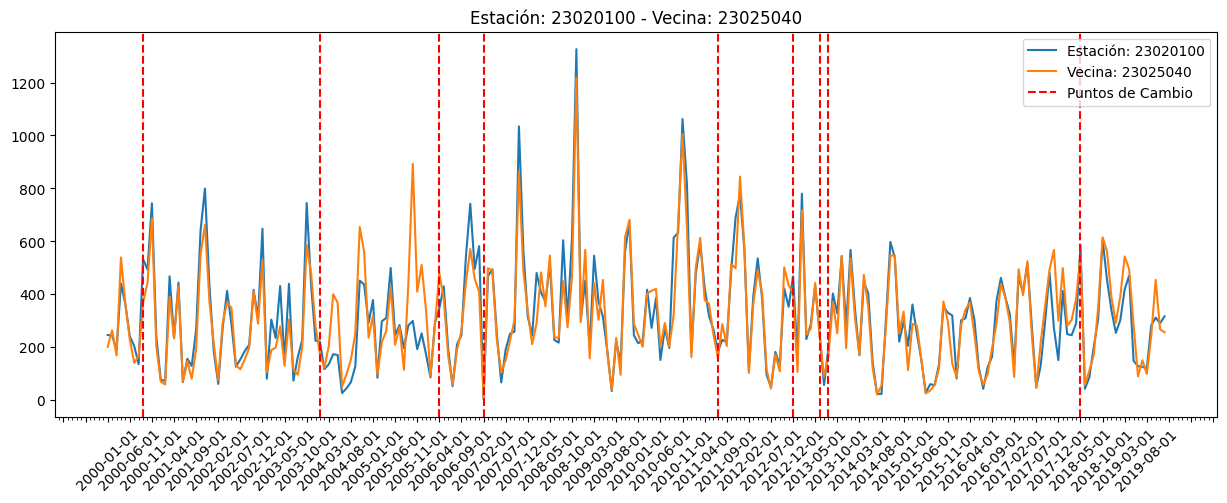

In [94]:
for zona in lista_zonas:
    print('Zona:',zona)
    path_zone = path+zona

    # leemos el archivo de estaciones vecinas
    neighboring_station_df = pd.read_csv(f'../datos/estaciones_vecinas_{zona}.csv')
    neighboring_station_df = neighboring_station_df.astype({'Estación': str})

    # shutil.rmtree(f'../datos/incrementos_anuales/{zona}/', ignore_errors=True)
    # path_output = f'../datos/incrementos_anuales/{zona}/'
    # os.makedirs(path_output)

    for file in os.listdir(path_zone):
        station = file.split('.')[0]

        # Guardamos los vecinos de cada estacion en la variable neighbors, esto se encuentra en la columnas Vecinas
        neighbors = json.loads(neighboring_station_df[neighboring_station_df["Estación"] == station]["Vecinas"].values[0])

        if neighbors != []:
            print('Estacion:', station, 'Vecinas:', neighbors)
            df = pd.read_csv(path_zone+'/'+file)
            change_points = pd.read_csv(f'../salidas/{zona}/{station}/worsley/change_points.csv')
            month = pd.merge(change_points, oni, left_on=['Punto de Cambio', 'Mes'], right_on=['Year', 'month'], how='left')

            # filtramos cuales puntos de cambio no coinciden con los fenomenos del niño o la niña y los dejamos en el dataframe
            month = month[(month["nino"] == 0) & (month["nina"] == 0)]

            if month.shape[0] > 0:
                print(f'Estación: {station} - Vecinas: {neighbors}')
                print('Punto de cambio no coincide con fenomeno del niño o la niña:')

                # Buscamos la estacion vecina con el menor valor de la raiz del error cuadratico medio
                min_RMSE = 1000000
                min_neighbor = ''
                min_neighbor_df = pd.DataFrame()

                for neighbor in neighbors:
                    print(f'Estación: {station} - Vecina: {neighbor}')
                    df_neighbor = pd.read_csv(f'{path_zone}/{neighbor}.csv')
                    print(month)
                    print(df.head(5))

                    # Aplicamos la formula de la rais del error cuadratico medio entre la estacion y la vecina
                    RMSE = np.sqrt(np.mean((df['Precipitación_imputada'] - df_neighbor['Precipitación_imputada']) ** 2))

                    if RMSE < min_RMSE:
                        min_RMSE = RMSE
                        min_neighbor = neighbor
                        min_neighbor_df = df_neighbor

                df_neighbor = min_neighbor_df
                neighbor = min_neighbor

                # tenemos los meses en cadena de texto, los pasamos a numero para  unirlos con el Año y generar fechas
                month['month_number'] = pd.to_datetime(month['Mes'], format='%B').dt.month
                month['Fecha'] = pd.to_datetime(month['Punto de Cambio'].astype(str) + '-' + month['month_number'].astype(str), format='%Y-%m')
                # eliminamos la parte de time y dejar solo la fecha, al igual que la de al columna de fecha de la estacion formato '%Y-%m-%d'
                month['Fecha'] = month['Fecha'].dt.strftime('%Y-%m-%d')

                # Graficamos la serie de tiempo de la estacion y la vecina
                # graficamos lineas verticales en los puntos de cambio
                plt.figure(figsize=(15, 5))
                plt.plot(df['Fecha'], df['Precipitación_imputada'])
                plt.plot(df_neighbor['Fecha'], df_neighbor['Precipitación_imputada'])
                
                for i in range(month.shape[0]):
                    plt.axvline(x=month.iloc[i]['Fecha'], color='r', linestyle='--')
                plt.title(f'Estación: {station} - Vecina: {neighbor}')
                # giramos las fechas para que se vean mejor y mostramos una cada 5
                plt.xticks(rotation=45)
                plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))
                plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
                plt.legend([f'Estación: {station}', f'Vecina: {neighbor}', 'Puntos de Cambio'])
                plt.show()
            break

Zona: MAGDALENA_MEDIO
Estacion: 23020100 Vecinas: [23025040]


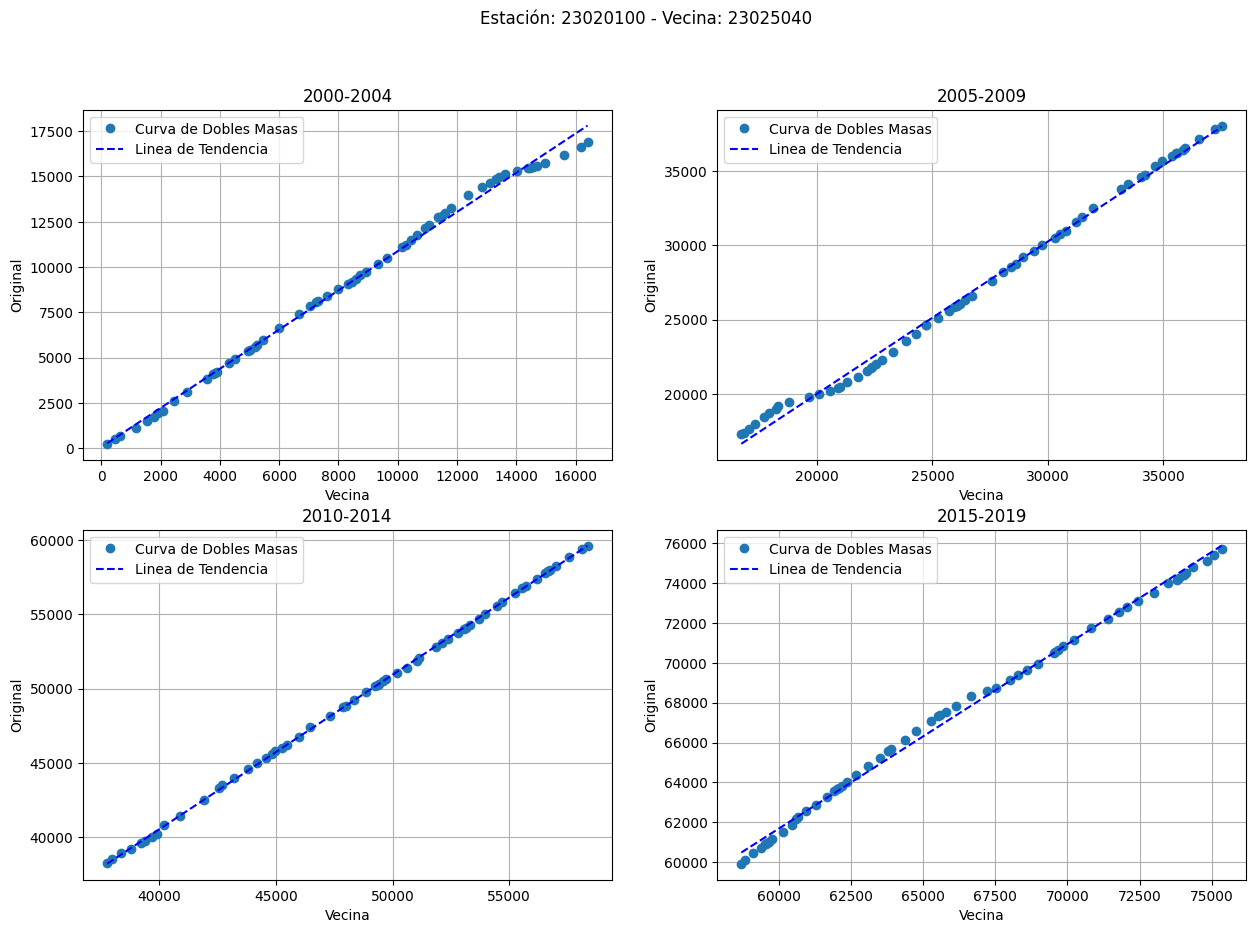

In [98]:
for zona in lista_zonas:
    print('Zona:',zona)
    path_zone = path+zona

    # leemos el archivo de estaciones vecinas
    neighboring_station_df = pd.read_csv(f'../datos/estaciones_vecinas_{zona}.csv')
    neighboring_station_df = neighboring_station_df.astype({'Estación': str})

    # shutil.rmtree(f'../datos/incrementos_anuales/{zona}/', ignore_errors=True)
    # path_output = f'../datos/incrementos_anuales/{zona}/'
    # os.makedirs(path_output)

    for file in os.listdir(path_zone):
        station = file.split('.')[0]

        # Guardamos los vecinos de cada estacion en la variable neighbors, esto se encuentra en la columnas Vecinas
        neighbors = json.loads(neighboring_station_df[neighboring_station_df["Estación"] == station]["Vecinas"].values[0])

        if neighbors != []:
            print('Estacion:', station, 'Vecinas:', neighbors)
            df = pd.read_csv(path_zone+'/'+file)
            change_points = pd.read_csv(f'../salidas/{zona}/{station}/worsley/change_points.csv')
            month = pd.merge(change_points, oni, left_on=['Punto de Cambio', 'Mes'], right_on=['Year', 'month'], how='left')

            # filtramos cuales puntos de cambio no coinciden con los fenomenos del niño o la niña y los dejamos en el dataframe
            month = month[(month["nino"] == 0) & (month["nina"] == 0)]

            if month.shape[0] > 0:
                # Buscamos la estacion vecina con el menor valor de la raiz del error cuadratico medio
                min_RMSE = 1000000
                min_neighbor = ''
                min_neighbor_df = pd.DataFrame()

                for neighbor in neighbors:
                    # print(f'Estación: {station} - Vecina: {neighbor}')
                    df_neighbor = pd.read_csv(f'{path_zone}/{neighbor}.csv')
                    # print(month)
                    # print(df.head(5))

                    # Aplicamos la formula de la rais del error cuadratico medio entre la estacion y la vecina
                    RMSE = np.sqrt(np.mean((df['Precipitación_imputada'] - df_neighbor['Precipitación_imputada']) ** 2))

                    if RMSE < min_RMSE:
                        min_RMSE = RMSE
                        min_neighbor = neighbor
                        min_neighbor_df = df_neighbor

                df_neighbor = min_neighbor_df
                neighbor = min_neighbor

                # tenemos los meses en cadena de texto, los pasamos a numero para  unirlos con el Año y generar fechas
                month['month_number'] = pd.to_datetime(month['Mes'], format='%B').dt.month
                month['Fecha'] = pd.to_datetime(month['Punto de Cambio'].astype(str) + '-' + month['month_number'].astype(str), format='%Y-%m')
                # eliminamos la parte de time y dejar solo la fecha, al igual que la de al columna de fecha de la estacion formato '%Y-%m-%d'
                month['Fecha'] = month['Fecha'].dt.strftime('%Y-%m-%d')

                df = df.merge(df_neighbor[['Fecha', 'Precipitación_imputada']], on='Fecha', suffixes=('', '_Vecina'))
                # Calcular acumulados
                df['Acumulado_Original'] = df['Precipitación_imputada'].cumsum()
                df['Acumulado_Vecina'] = df['Precipitación_imputada_Vecina'].cumsum()

                tam = df.shape[0]
                # definimos los rangos de datos para graficar en 4 partes
                rango1 = tam//4
                rango2 = rango1*2
                rango3 = rango1*3

                # Crear la curva de dobles masas en 4 partes, es decir 4 graficas en 2x2 para poder visualizarla mejor, mostrando en cada una 1/4 de la serie
                fig, axs = plt.subplots(2, 2, figsize=(15, 10))
                fig.suptitle(f'Estación: {station} - Vecina: {neighbor}')
                axs[0, 0].plot(df['Acumulado_Vecina'][:rango1], df['Acumulado_Original'][:rango1], 'o', label='Curva de Dobles Masas')
                # graficamos la linea de tendencia
                z = np.polyfit(df['Acumulado_Vecina'][:rango1], df['Acumulado_Original'][:rango1], 1)
                p = np.poly1d(z)
                axs[0, 0].plot(df['Acumulado_Vecina'][:rango1], p(df['Acumulado_Vecina'][:rango1]), "b--", label='Linea de Tendencia')
                axs[0, 0].set_title('2000-2004')
                axs[0, 0].legend()
                axs[0, 0].grid()
                axs[0, 0].set_xlabel('Vecina')
                axs[0, 0].set_ylabel('Original')
                axs[0, 1].plot(df['Acumulado_Vecina'][rango1:rango2], df['Acumulado_Original'][rango1:rango2], 'o', label='Curva de Dobles Masas')
                z = np.polyfit(df['Acumulado_Vecina'][rango1:rango2], df['Acumulado_Original'][rango1:rango2], 1)
                p = np.poly1d(z)
                axs[0, 1].plot(df['Acumulado_Vecina'][rango1:rango2], p(df['Acumulado_Vecina'][rango1:rango2]), "b--", label='Linea de Tendencia')
                axs[0, 1].set_title('2005-2009')
                axs[0, 1].legend()
                axs[0, 1].grid()
                axs[0, 1].set_xlabel('Vecina')
                axs[0, 1].set_ylabel('Original')
                axs[1, 0].plot(df['Acumulado_Vecina'][rango2:rango3], df['Acumulado_Original'][rango2:rango3], 'o', label='Curva de Dobles Masas')
                z = np.polyfit(df['Acumulado_Vecina'][rango2:rango3], df['Acumulado_Original'][rango2:rango3], 1)
                p = np.poly1d(z)
                axs[1, 0].plot(df['Acumulado_Vecina'][rango2:rango3], p(df['Acumulado_Vecina'][rango2:rango3]), "b--", label='Linea de Tendencia')
                axs[1, 0].set_title('2010-2014')
                axs[1, 0].legend()
                axs[1, 0].grid()
                axs[1, 0].set_xlabel('Vecina')
                axs[1, 0].set_ylabel('Original')
                axs[1, 1].plot(df['Acumulado_Vecina'][rango3:], df['Acumulado_Original'][rango3:], 'o', label='Curva de Dobles Masas')
                z = np.polyfit(df['Acumulado_Vecina'][rango3:], df['Acumulado_Original'][rango3:], 1)
                p = np.poly1d(z)
                axs[1, 1].plot(df['Acumulado_Vecina'][rango3:], p(df['Acumulado_Vecina'][rango3:]), "b--", label='Linea de Tendencia')
                axs[1, 1].set_title('2015-2019')
                axs[1, 1].legend()
                axs[1, 1].grid()
                axs[1, 1].set_xlabel('Vecina')
                axs[1, 1].set_ylabel('Original')
                plt.show()
            break

Zona: MAGDALENA_MEDIO
Estacion: 23020100 Vecinas: [23025040]
Mes: January - Punto de Cambio: 2004


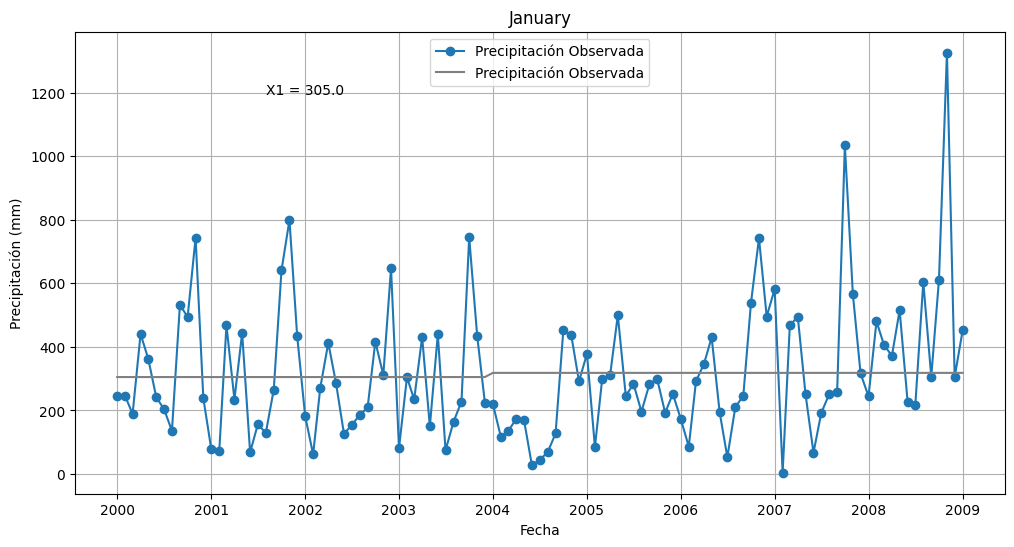

Mes: February - Punto de Cambio: 2007


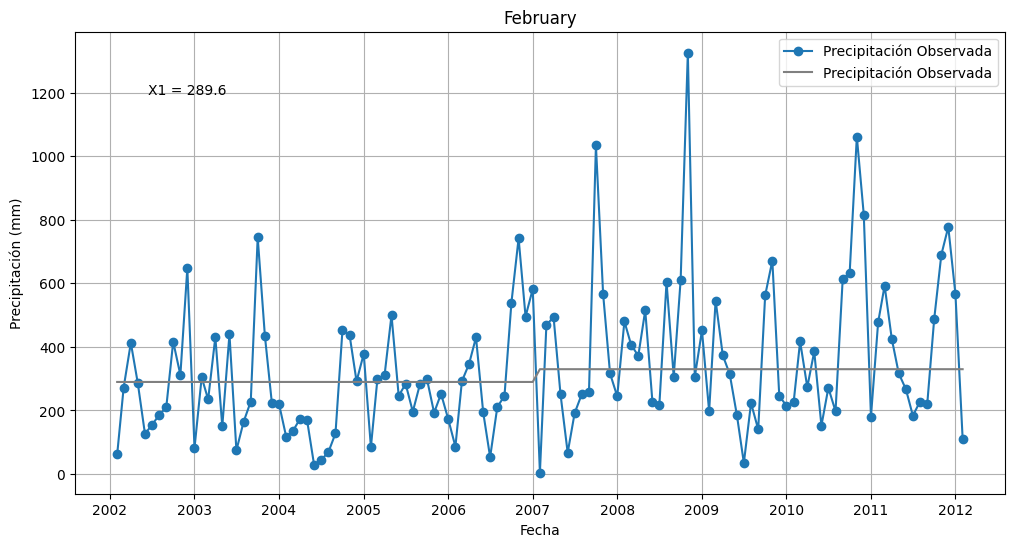

Mes: April - Punto de Cambio: 2006


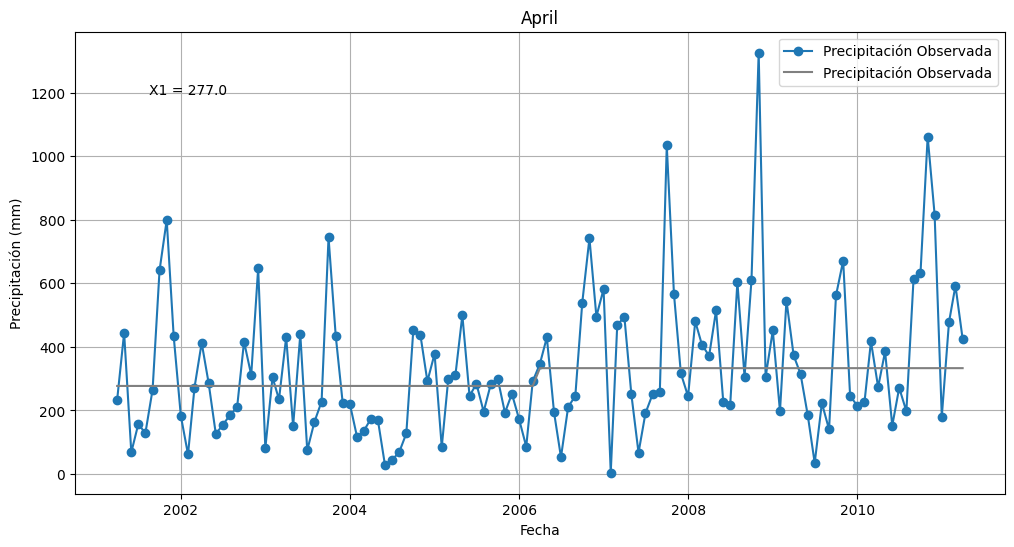

Mes: May - Punto de Cambio: 2018


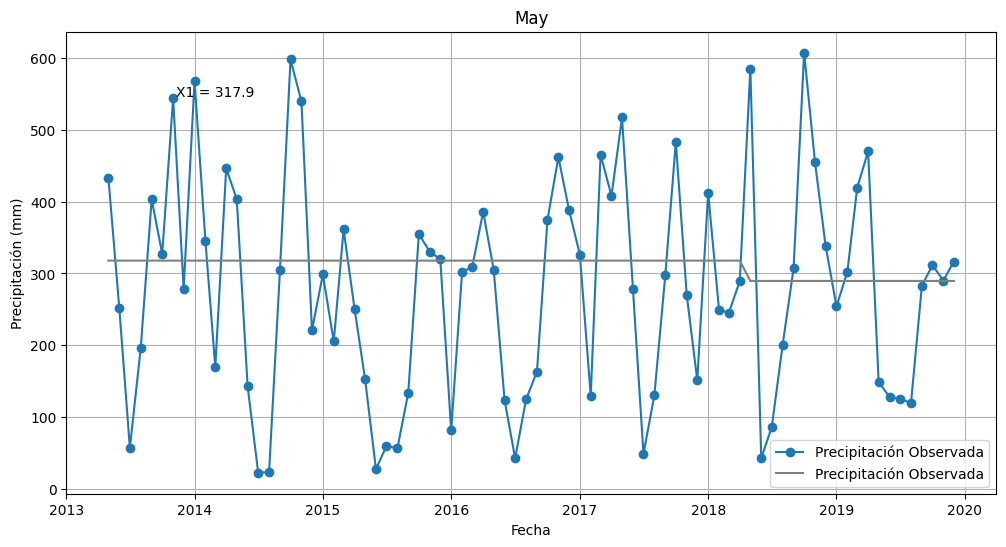

Mes: June - Punto de Cambio: 2013


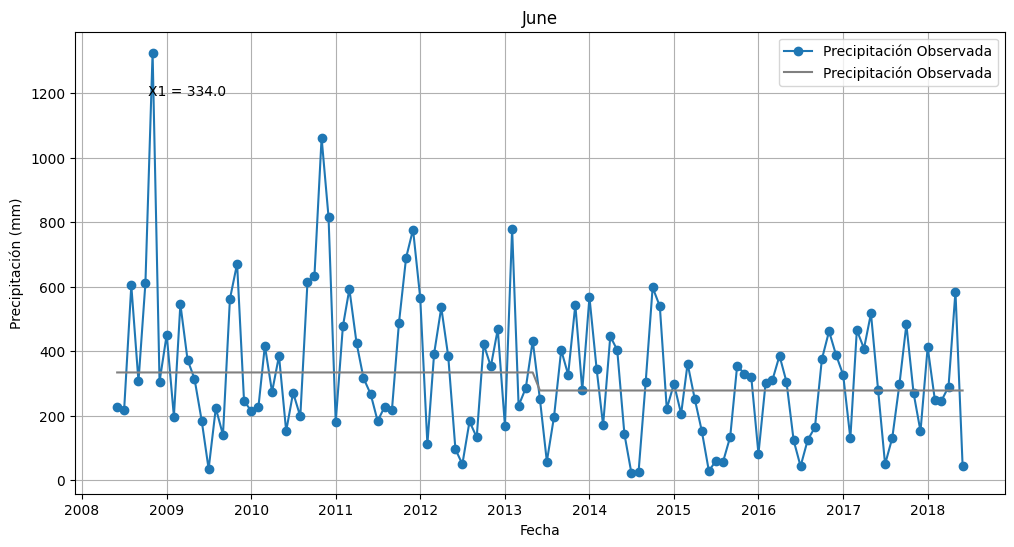

Mes: July - Punto de Cambio: 2011


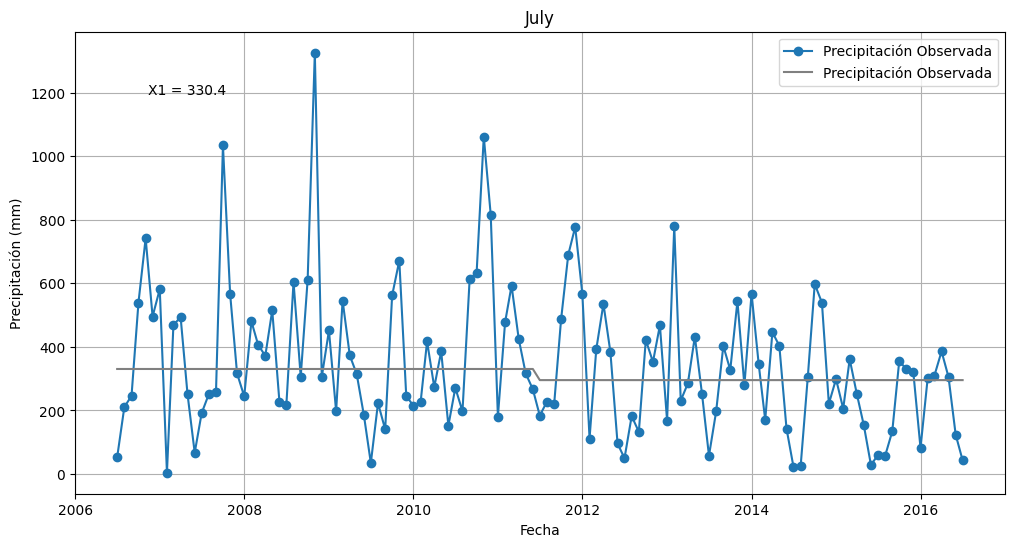

Mes: August - Punto de Cambio: 2013


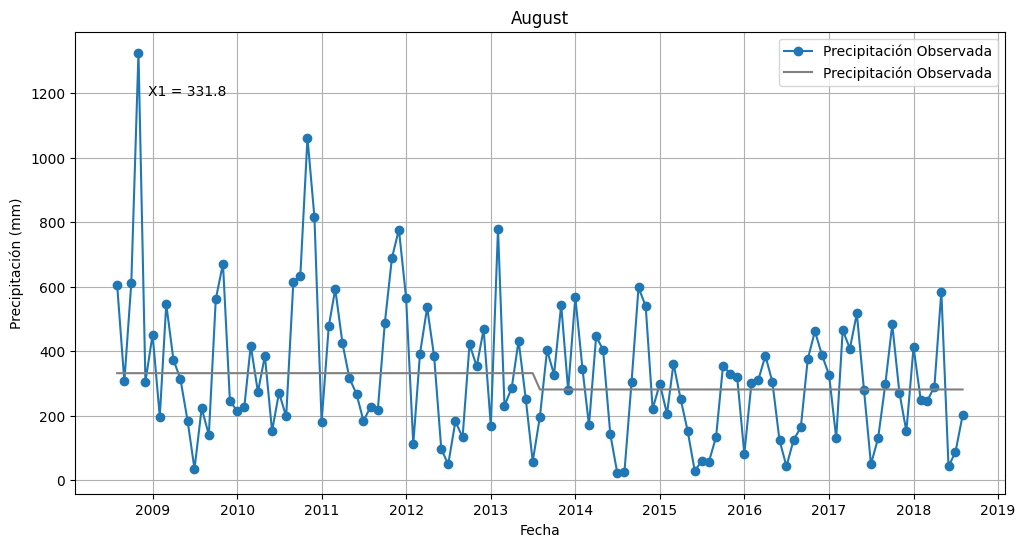

Mes: September - Punto de Cambio: 2000


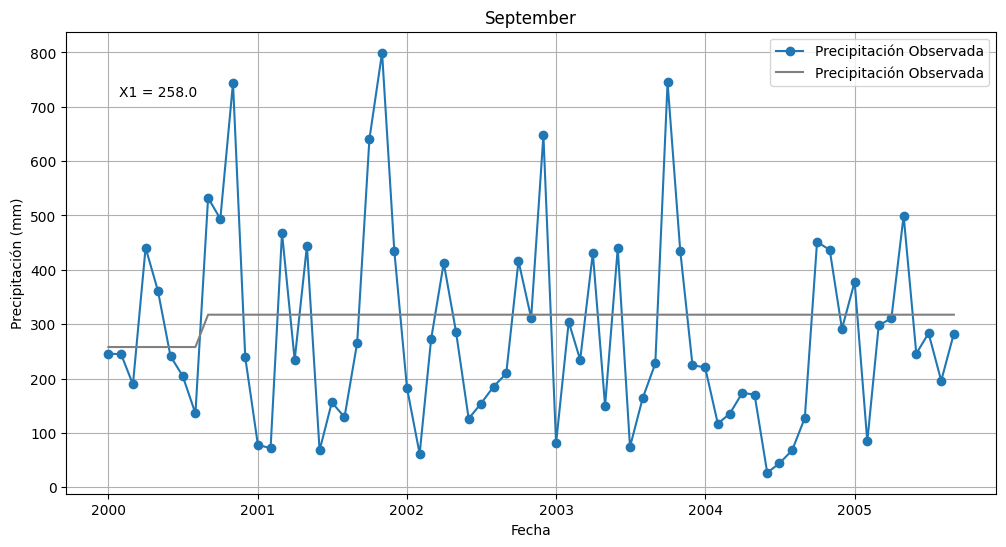

Mes: December - Punto de Cambio: 2012


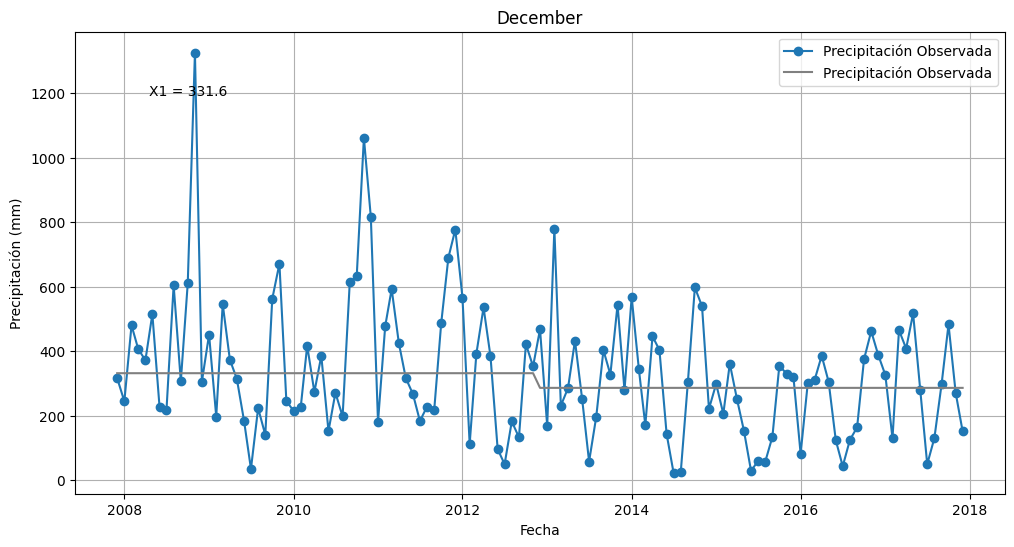

In [263]:
for zona in lista_zonas:
    print('Zona:',zona)
    path_zone = path+zona

    # leemos el archivo de estaciones vecinas
    neighboring_station_df = pd.read_csv(f'../datos/estaciones_vecinas_{zona}.csv')
    neighboring_station_df = neighboring_station_df.astype({'Estación': str})

    # shutil.rmtree(f'../datos/incrementos_anuales/{zona}/', ignore_errors=True)
    # path_output = f'../datos/incrementos_anuales/{zona}/'
    # os.makedirs(path_output)

    for file in os.listdir(path_zone):
        station = file.split('.')[0]

        # Guardamos los vecinos de cada estacion en la variable neighbors, esto se encuentra en la columnas Vecinas
        neighbors = json.loads(neighboring_station_df[neighboring_station_df["Estación"] == station]["Vecinas"].values[0])

        if neighbors != []:
            print('Estacion:', station, 'Vecinas:', neighbors)
            df = pd.read_csv(path_zone+'/'+file)
            change_points = pd.read_csv(f'../salidas/{zona}/{station}/worsley/change_points.csv')
            month = pd.merge(change_points, oni, left_on=['Punto de Cambio', 'Mes'], right_on=['Year', 'month'], how='left')

            # filtramos cuales puntos de cambio no coinciden con los fenomenos del niño o la niña y los dejamos en el dataframe
            month = month[(month["nino"] == 0) & (month["nina"] == 0)]

            if month.shape[0] > 0:

                # Buscamos la estacion vecina con el menor valor de la raiz del error cuadratico medio
                min_RMSE = 1000000
                min_neighbor = ''
                min_neighbor_df = pd.DataFrame()

                for neighbor in neighbors:
                    df_neighbor = pd.read_csv(f'{path_zone}/{neighbor}.csv')
                    # Aplicamos la formula de la rais del error cuadratico medio entre la estacion y la vecina
                    RMSE = np.sqrt(np.mean((df['Precipitación_imputada'] - df_neighbor['Precipitación_imputada']) ** 2))

                    if RMSE < min_RMSE:
                        min_RMSE = RMSE
                        min_neighbor = neighbor
                        min_neighbor_df = df_neighbor

                df_neighbor = min_neighbor_df
                neighbor = min_neighbor

                # tenemos los meses en cadena de texto, los pasamos a numero para  unirlos con el Año y generar fechas
                month['month_number'] = pd.to_datetime(month['Mes'], format='%B').dt.month
                month['Fecha'] = pd.to_datetime(month['Punto de Cambio'].astype(str) + '-' + month['month_number'].astype(str), format='%Y-%m')
                # eliminamos la parte de time y dejar solo la fecha, al igual que la de al columna de fecha de la estacion formato '%Y-%m-%d'
                month['Fecha'] = month['Fecha'].dt.strftime('%Y-%m-%d')

                df = df.merge(df_neighbor[['Fecha', 'Precipitación_imputada']], on='Fecha', suffixes=('', '_Vecina'))

                # Calcular acumulados
                df['Acumulado_Original'] = df['Precipitación_imputada'].cumsum()
                df['Acumulado_Vecina'] = df['Precipitación_imputada_Vecina'].cumsum()

                for m in range(month.shape[0]):
                    print(f"Mes: {month.iloc[m]['Mes']} - Punto de Cambio: {month.iloc[m]['Punto de Cambio']}")
                    # Asegurarse de que la columna de fecha sea del tipo datetime
                    df['Fecha'] = pd.to_datetime(df['Fecha'])

                    min_date = pd.to_datetime(df['Fecha'].min())
                    max_date = pd.to_datetime(df['Fecha'].max())

                    change_point = pd.to_datetime(month.iloc[m]['Fecha'])
                    less_5_years = pd.to_datetime(change_point) - pd.DateOffset(years=5)

                    periodo_1 = df[(df['Fecha'] < change_point)]
                    periodo_2 = df[(df['Fecha'] >= change_point)]

                    promedio_1 = periodo_1['Precipitación_imputada'].mean()
                    promedio_2 = periodo_2['Precipitación_imputada'].mean()

                    # sumamos 5 años al punto de cambio para obtener el rango de 5 años despues del cambio
                    plus_5_years = pd.to_datetime(change_point) + pd.DateOffset(years=5)
                    change_point_plus_5 = plus_5_years.strftime('%Y-%m-%d')
                    less_5_years = pd.to_datetime(change_point) - pd.DateOffset(years=5)
                    change_point_less_5 = less_5_years.strftime('%Y-%m-%d')

                    df_projection = df[(df['Fecha'] >= change_point_less_5) & (df['Fecha'] <= change_point_plus_5)]
                    # Generamos una nueva columna para el cambio de nivel de precipitación, donde mostramos el valor de promedio 1 antes del cambio y promedio 2 despues del cambio
                    df_projection["change_point"] = np.where(df_projection['Fecha'] < change_point, promedio_1, promedio_2)

                    # Crear el gráfico de línea mostrando unicamente un lapso de maximo 5 años a cada lado del punto de cambio
                    plt.figure(figsize=(12, 6))
                    plt.plot(df_projection['Fecha'], df_projection['Precipitación_imputada'], marker='o', linestyle='-', label='Precipitación Observada')
                    plt.plot(df_projection['Fecha'], df_projection['change_point'], color='gray', linestyle='-', label='Precipitación Observada')

                    max_value = df_projection['Precipitación_imputada'].max() * 9 / 10

                    if change_point < min_date + pd.DateOffset(years=5):
                        plt.text(df_projection['Fecha'].iloc[len(periodo_1) // 2], max_value, f'X1 = {promedio_1:.1f}', ha='center')
                    else:
                        plt.text(df_projection['Fecha'].iloc[10], max_value, f'X1 = {promedio_1:.1f}', ha='center')
                    # plt.text(df_projection['Fecha'].iloc[len(periodo_1) + 24], promedio_2 + 550, f'X2 = {promedio_2:.1f}', ha='center')

                    plt.xlabel('Fecha')
                    plt.ylabel('Precipitación (mm)')
                    plt.title(month.iloc[m]['Mes'])
                    plt.legend()
                    plt.grid(True)
                    plt.show()
            break

Zona: MAGDALENA_MEDIO
Estacion: 23020100 Vecinas: [23025040]
Mes: January - Punto de Cambio: 2004


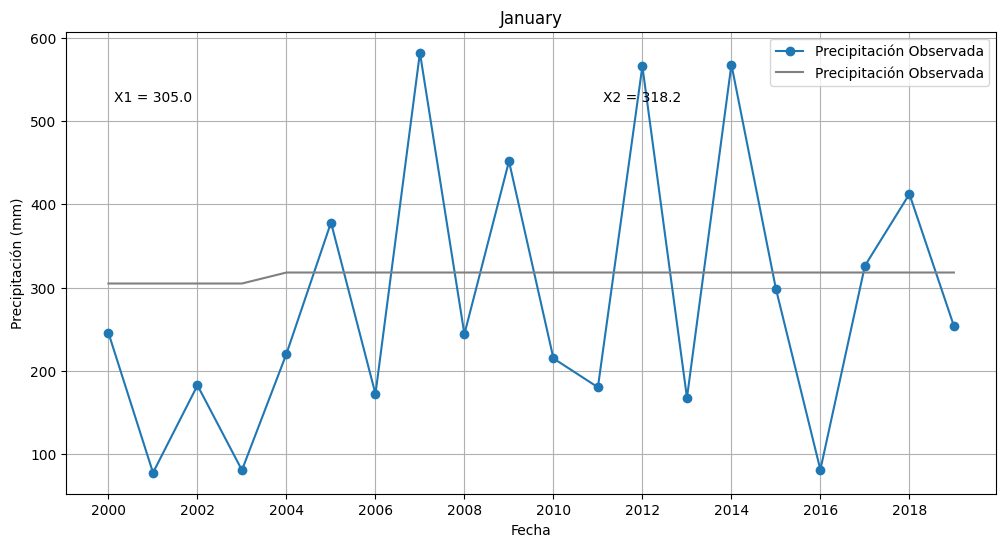

Mes: February - Punto de Cambio: 2007


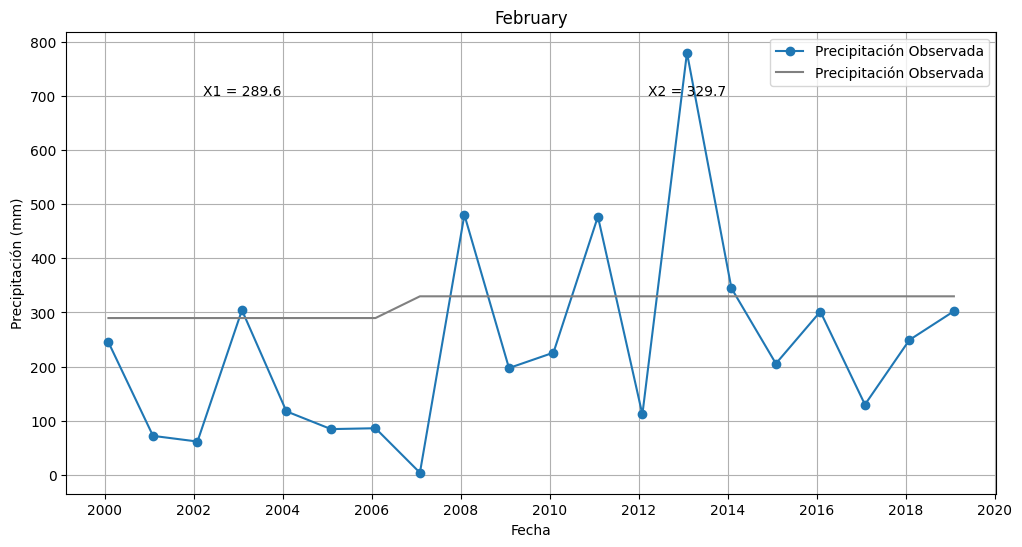

Mes: April - Punto de Cambio: 2006


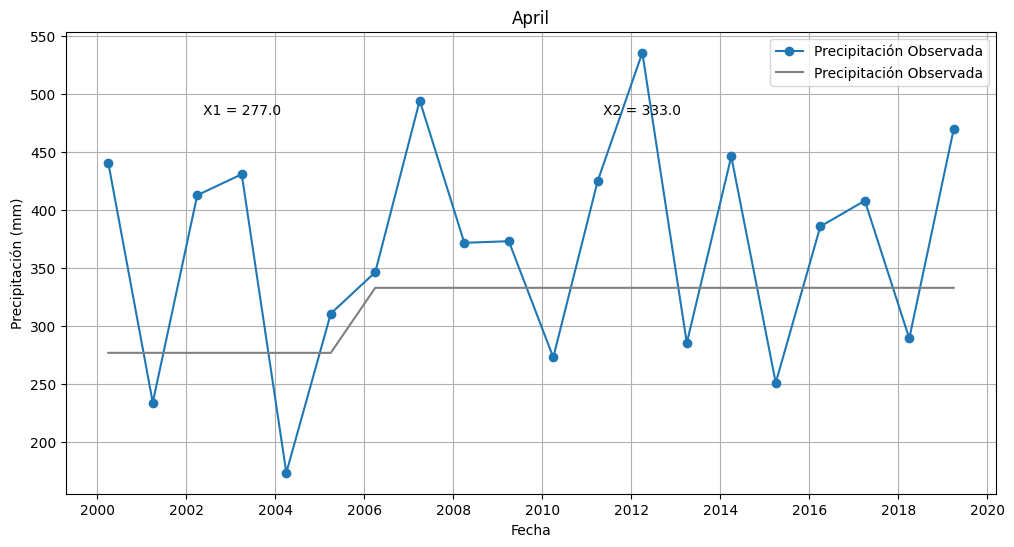

Mes: May - Punto de Cambio: 2018


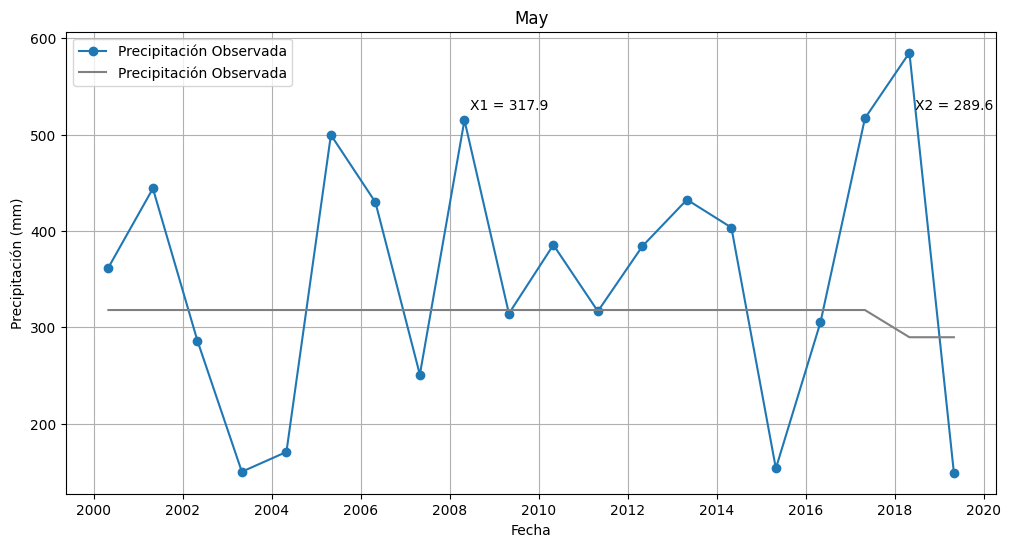

Mes: June - Punto de Cambio: 2013


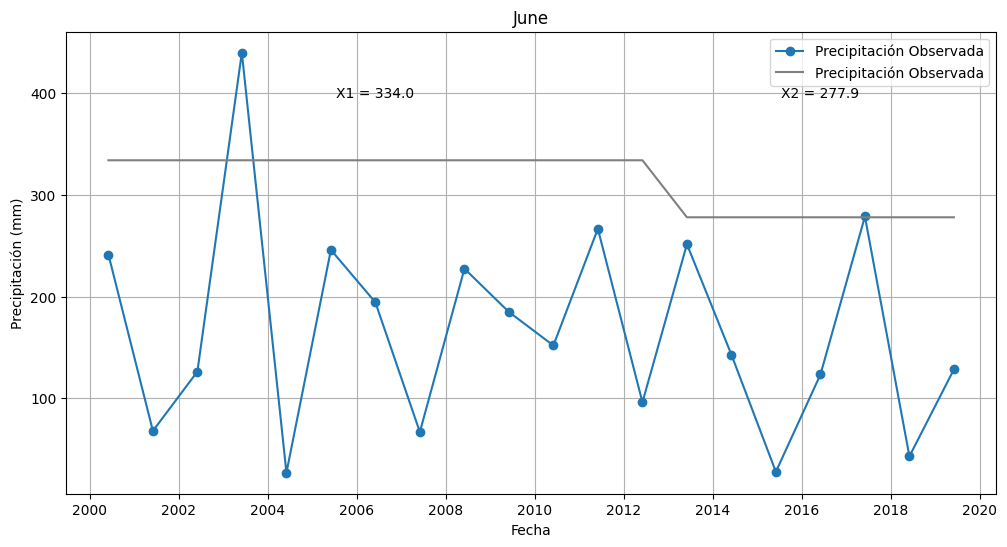

Mes: July - Punto de Cambio: 2011


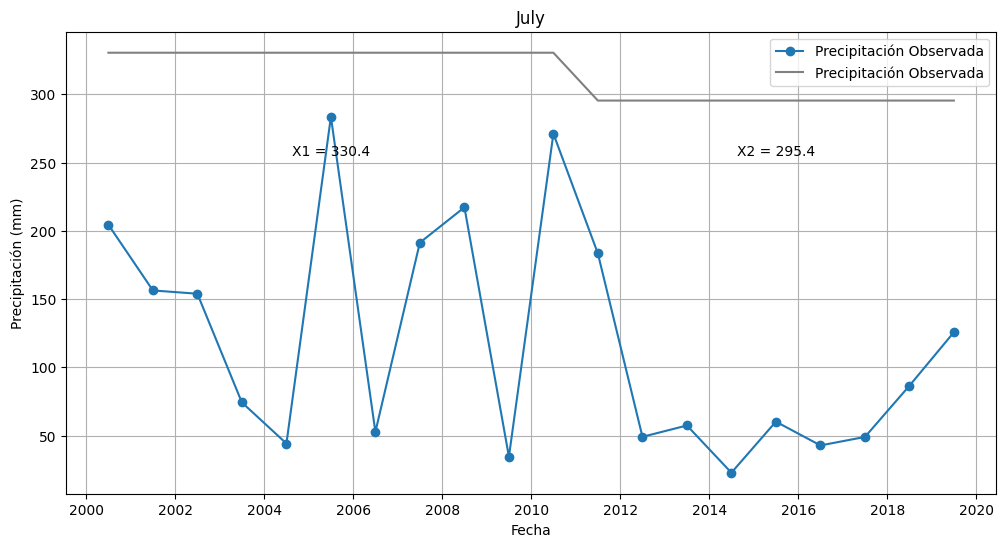

Mes: August - Punto de Cambio: 2013


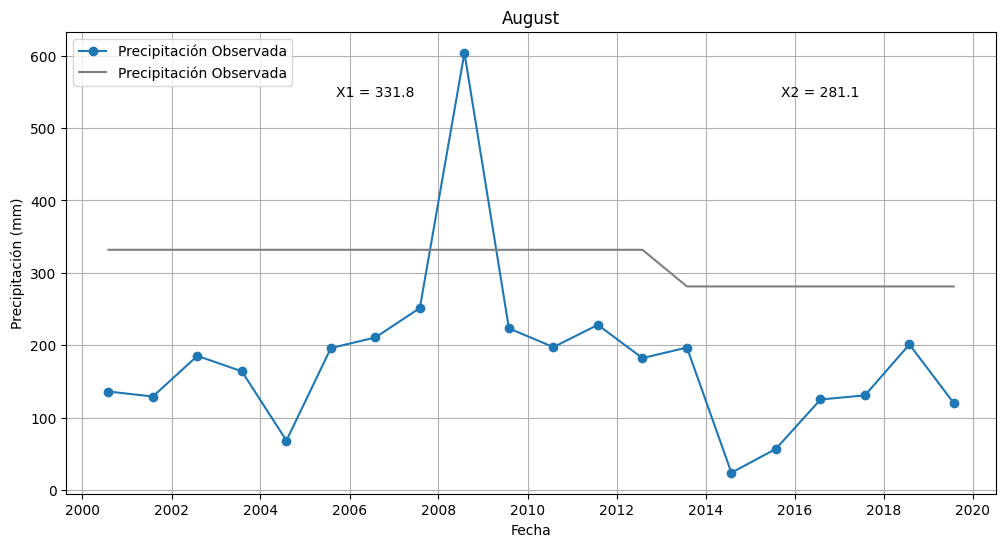

Mes: September - Punto de Cambio: 2000


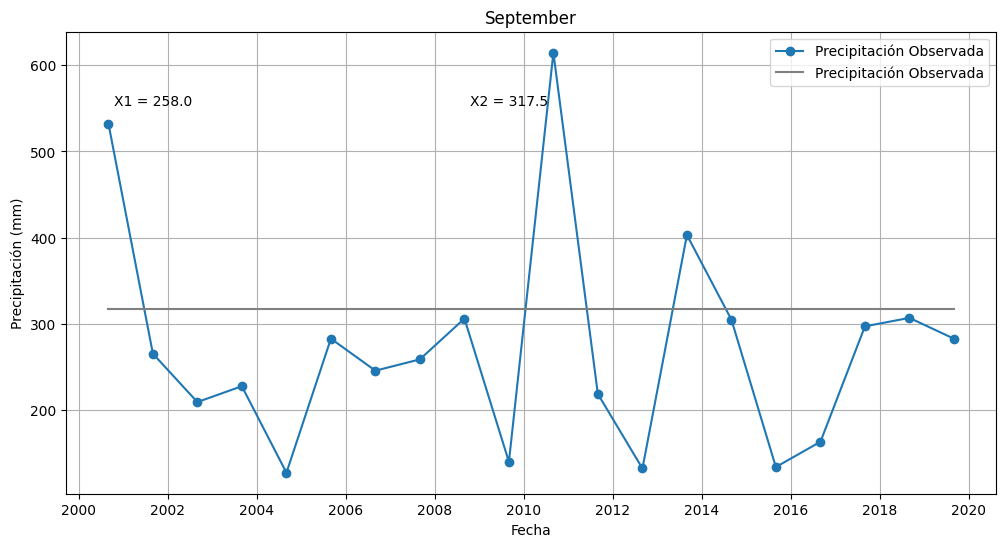

Mes: December - Punto de Cambio: 2012


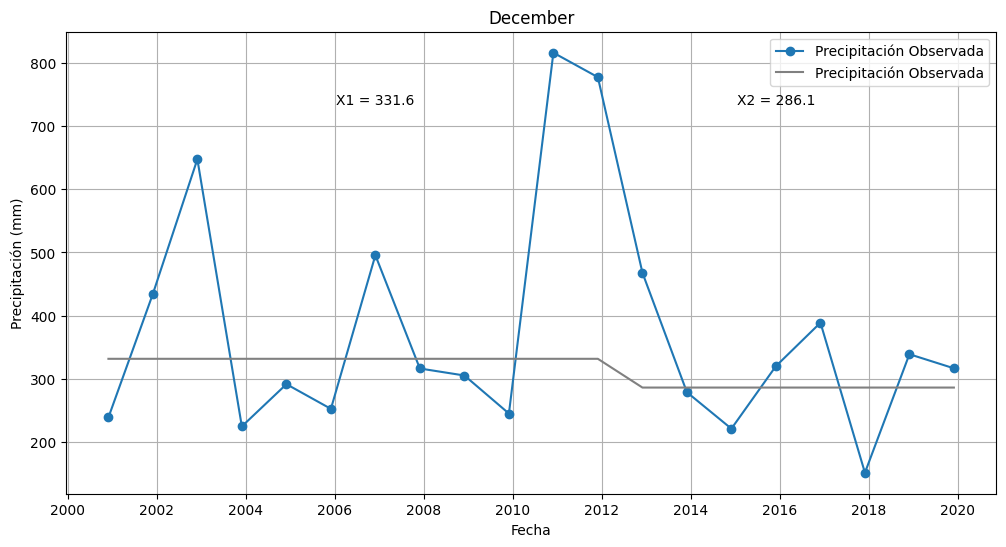

In [12]:
for zona in lista_zonas:
    print('Zona:',zona)
    path_zone = path+zona

    # leemos el archivo de estaciones vecinas
    neighboring_station_df = pd.read_csv(f'../datos/estaciones_vecinas_{zona}.csv')
    neighboring_station_df = neighboring_station_df.astype({'Estación': str})

    # shutil.rmtree(f'../datos/incrementos_anuales/{zona}/', ignore_errors=True)
    # path_output = f'../datos/incrementos_anuales/{zona}/'
    # os.makedirs(path_output)

    for file in os.listdir(path_zone):
        station = file.split('.')[0]
        neighbors = json.loads(neighboring_station_df[neighboring_station_df["Estación"] == station]["Vecinas"].values[0].replace(" ", ","))

        if neighbors != []:
            print('Estacion:', station, 'Vecinas:', neighbors)
            df = pd.read_csv(path_zone+'/'+file)
            change_points = pd.read_csv(f'../salidas/{zona}/{station}/worsley/change_points.csv')
            month = pd.merge(change_points, oni, left_on=['Punto de Cambio', 'Mes'], right_on=['Year', 'month'], how='left')

            # filtramos cuales puntos de cambio no coinciden con los fenomenos del niño o la niña y los dejamos en el dataframe
            month = month[(month["nino"] == 0) & (month["nina"] == 0)]

            if month.shape[0] > 0:

                # Buscamos la estacion vecina con el menor valor de la raiz del error cuadratico medio
                min_RMSE = 1000000
                min_neighbor = ''
                min_neighbor_df = pd.DataFrame()

                for neighbor in neighbors:
                    df_neighbor = pd.read_csv(f'{path_zone}/{neighbor}.csv')
                    # Aplicamos la formula de la rais del error cuadratico medio entre la estacion y la vecina
                    RMSE = np.sqrt(np.mean((df['Precipitación_imputada'] - df_neighbor['Precipitación_imputada']) ** 2))

                    if RMSE < min_RMSE:
                        min_RMSE = RMSE
                        min_neighbor = neighbor
                        min_neighbor_df = df_neighbor

                df_neighbor = min_neighbor_df
                neighbor = min_neighbor

                # tenemos los meses en cadena de texto, los pasamos a numero para  unirlos con el Año y generar fechas
                month['month_number'] = pd.to_datetime(month['Mes'], format='%B').dt.month
                month['Fecha'] = pd.to_datetime(month['Punto de Cambio'].astype(str) + '-' + month['month_number'].astype(str), format='%Y-%m')
                # eliminamos la parte de time y dejar solo la fecha, al igual que la de al columna de fecha de la estacion formato '%Y-%m-%d'
                month['Fecha'] = month['Fecha'].dt.strftime('%Y-%m-%d')

                df = df.merge(df_neighbor[['Fecha', 'Precipitación_imputada']], on='Fecha', suffixes=('', '_Vecina'))

                # Calcular acumulados
                df['Acumulado_Original'] = df['Precipitación_imputada'].cumsum()
                df['Acumulado_Vecina'] = df['Precipitación_imputada_Vecina'].cumsum()

                for m in range(month.shape[0]):
                    print(f"Mes: {month.iloc[m]['Mes']} - Punto de Cambio: {month.iloc[m]['Punto de Cambio']}")
                    # Asegurarse de que la columna de fecha sea del tipo datetime
                    df['Fecha'] = pd.to_datetime(df['Fecha'])

                    min_date = pd.to_datetime(df['Fecha'].min())
                    max_date = pd.to_datetime(df['Fecha'].max())

                    change_point = pd.to_datetime(month.iloc[m]['Fecha'])

                    periodo_1 = df[(df['Fecha'] < change_point)]
                    periodo_2 = df[(df['Fecha'] >= change_point)]

                    promedio_1 = periodo_1['Precipitación_imputada'].mean()
                    promedio_2 = periodo_2['Precipitación_imputada'].mean()

                    # Filtramos por el mes del punto de cambio
                    df_projection = df[df['Mes'] == month.iloc[m]['Mes']]
                    # Generamos una nueva columna para el cambio de nivel de precipitación, donde mostramos el valor de promedio 1 antes del cambio y promedio 2 despues del cambio
                    df_projection["change_point"] = np.where(df_projection['Fecha'] < change_point, promedio_1, promedio_2)

                    # Crear el gráfico de línea mostrando unicamente un lapso de maximo 5 años a cada lado del punto de cambio
                    plt.figure(figsize=(12, 6))
                    plt.plot(df_projection['Fecha'], df_projection['Precipitación_imputada'], marker='o', linestyle='-', label='Precipitación Observada')
                    plt.plot(df_projection['Fecha'], df_projection['change_point'], color='gray', linestyle='-', label='Precipitación Observada')

                    max_value = df_projection['Precipitación_imputada'].max() * 9 / 10
                    # buscamos el indice del punto de cambio en el dataframe para poder mostrar el valor de X1
                    idx = df_projection[df_projection['Fecha'] == change_point].index[0]
                    if change_point < min_date + pd.DateOffset(years=5):
                        plt.text(df_projection['Fecha'].iloc[1], max_value, f'X1 = {promedio_1:.1f}', ha='center')
                    else:
                        plt.text(df_projection['Fecha'].iloc[int(len(periodo_1) /12) // 2], max_value, f'X1 = {promedio_1:.1f}', ha='center')
                    
                    if change_point > max_date - pd.DateOffset(years=5):
                        plt.text(df_projection['Fecha'].iloc[-1], max_value, f'X2 = {promedio_2:.1f}', ha='center')
                    else:
                        plt.text(df_projection['Fecha'].iloc[int(len(periodo_1)/12) + (int(len(periodo_2) /12) // 2)], max_value, f'X2 = {promedio_2:.1f}', ha='center')
                    plt.xlabel('Fecha')
                    plt.ylabel('Precipitación (mm)')
                    plt.title(month.iloc[m]['Mes'])
                    plt.legend()
                    plt.grid(True)
                    plt.show()
            break

In [258]:
from sklearn.linear_model import LinearRegression
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

def calcular_tendencia(data, x_col, y_col):
    X = data[x_col].values.reshape(-1, 1)
    y = data[y_col].values
    reg = LinearRegression().fit(X, y)
    pendiente = reg.coef_[0]
    intercepto = reg.intercept_
    r2 = reg.score(X, y)
    return pendiente, intercepto, r2

for zona in lista_zonas:
    print('Zona:',zona)
    path_zone = path+zona

    # leemos el archivo de estaciones vecinas
    neighboring_station_df = pd.read_csv(f'../datos/estaciones_vecinas_{zona}.csv')
    neighboring_station_df = neighboring_station_df.astype({'Estación': str})

    shutil.rmtree(f'../datos/series_homogenizadas/{zona}/', ignore_errors=True)
    path_output = f'../datos/series_homogenizadas/{zona}/'
    os.makedirs(path_output)

    for file in os.listdir(path_zone):
        station = file.split('.')[0]

        # Guardamos los vecinos de cada estacion en la variable neighbors, esto se encuentra en la columnas Vecinas
        neighbors = json.loads(neighboring_station_df[neighboring_station_df["Estación"] == station]["Vecinas"].values[0])

        if neighbors != []:
            print('Estacion:', station, 'Vecinas:', neighbors)
            change_points = pd.read_csv(f'../salidas/{zona}/{station}/worsley/change_points.csv')
            month = pd.merge(change_points, oni, left_on=['Punto de Cambio', 'Mes'], right_on=['Year', 'month'], how='left')

            path_output_plots = f'../salidas/{zona}/{station}/homogenizacion/'
            # filtramos cuales puntos de cambio no coinciden con los fenomenos del niño o la niña y los dejamos en el dataframe
            month = month[(month["nino"] == 0) & (month["nina"] == 0)]

            if month.shape[0] > 0:
                df = pd.read_csv(path_zone+'/'+file)

                # Buscamos la estacion vecina con el menor valor de la raiz del error cuadratico medio
                min_RMSE = 1000000
                min_neighbor = ''
                min_neighbor_df = pd.DataFrame()

                for neighbor in neighbors:
                    df_neighbor = pd.read_csv(f'{path_zone}/{neighbor}.csv')
                    # Aplicamos la formula de la rais del error cuadratico medio entre la estacion y la vecina
                    RMSE = np.sqrt(np.mean((df['Precipitación_imputada'] - df_neighbor['Precipitación_imputada']) ** 2))

                    if RMSE < min_RMSE:
                        min_RMSE = RMSE
                        min_neighbor = neighbor
                        min_neighbor_df = df_neighbor

                df_neighbor = min_neighbor_df
                neighbor = min_neighbor

                # tenemos los meses en cadena de texto, los pasamos a numero para  unirlos con el Año y generar fechas
                month['month_number'] = pd.to_datetime(month['Mes'], format='%B').dt.month
                month['Fecha'] = pd.to_datetime(month['Punto de Cambio'].astype(str) + '-' + month['month_number'].astype(str), format='%Y-%m')

                # eliminamos la parte de time y dejar solo la fecha, al igual que la de al columna de fecha de la estacion formato '%Y-%m-%d'
                month['Fecha'] = month['Fecha'].dt.strftime('%Y-%m-%d')

                df = df.merge(df_neighbor[['Fecha', 'Precipitación_imputada']], on='Fecha', suffixes=('', '_Vecina'))
                df["Estación"] = station

                df['Precipitación_ajustada'] = df['Precipitación_imputada']
                df['Vecina'] = ""
                df['factor_ajuste'] = 1
                # Separamos los meses que no vamos a procesar
                df_out = df[df['Mes'].isin(month['Mes']) == False]
                df_out = df_out[['Estación', 'Fecha', 'Mes', 'Año', 'Precipitación_imputada', 'Precipitación_ajustada', 'Vecina', 'factor_ajuste']]

                for m in range(month.shape[0]):

                    path_output_month_plots = f'{path_output_plots}{month.iloc[m]["Mes"]}/'
                    shutil.rmtree(path_output_month_plots, ignore_errors=True)

                    if not os.path.exists(path_output_month_plots):
                        os.makedirs(path_output_month_plots)

                    df_2 = df.copy()
                    # Asegurarse de que la columna de fecha sea del tipo datetime
                    df_2['Fecha'] = pd.to_datetime(df_2['Fecha'])
                    df_2 = df_2[df_2['Mes'] == month.iloc[m]['Mes']]

                    if month.iloc[m]['Punto de Cambio'] in [df["Año"].min(), df["Año"].max()]:
                        df_2 = df_2[['Estación', 'Fecha', 'Mes', 'Año', 'Precipitación_imputada', 'Precipitación_ajustada', 'Vecina', 'factor_ajuste']]
                        df_2["Fecha"] = df_2["Fecha"].dt.strftime('%Y-%m-%d')
                        df_out = pd.concat([df_out, df_2])
                        continue
                    print(f"Mes: {month.iloc[m]['Mes']} - Punto de Cambio: {month.iloc[m]['Punto de Cambio']}")
                    
                    # Calcular acumulados
                    df_2['Acumulado_Original'] = df_2['Precipitación_imputada'].cumsum()
                    df_2['Acumulado_Vecina'] = df_2['Precipitación_imputada_Vecina'].cumsum()

                    min_date = pd.to_datetime(df_2['Fecha'].min())
                    max_date = pd.to_datetime(df_2['Fecha'].max())

                    change_point = pd.to_datetime(month.iloc[m]['Fecha'])

                    periodo_1 = df_2[(df_2['Fecha'] < change_point)]
                    periodo_2 = df_2[(df_2['Fecha'] >= change_point)]

                    pendiente_antes, intercepto_antes, r2_antes = calcular_tendencia(periodo_1, 'Acumulado_Vecina', 'Acumulado_Original')
                    pendiente_despues, intercepto_despues, r2_despues = calcular_tendencia(periodo_2, 'Acumulado_Vecina', 'Acumulado_Original')
                    print(f"Antes del cambio: Pendiente = {pendiente_antes}, Intercepto = {intercepto_antes}, R² = {r2_antes}")
                    print(f"Después del cambio: Pendiente = {pendiente_despues}, Intercepto = {intercepto_despues}, R² = {r2_despues}")

                    if pendiente_despues > pendiente_antes:
                        factor_ajuste = pendiente_antes / pendiente_despues
                        print("Ajuste los datos después del punto de cambio con factor:", factor_ajuste)
                        df_2.loc[df_2['Fecha'] >= change_point, 'Precipitación_ajustada'] *= factor_ajuste
                        df_2.loc[df_2['Fecha'] >= change_point, 'factor_ajuste'] = factor_ajuste
                    else:
                        factor_ajuste = pendiente_despues / pendiente_antes
                        print("Ajuste los datos antes del punto de cambio con factor:", factor_ajuste)
                        df_2.loc[df_2['Fecha'] < change_point, 'Precipitación_ajustada'] *= factor_ajuste
                        df_2.loc[df_2['Fecha'] < change_point, 'factor_ajuste'] = factor_ajuste

                    # Graficamos los datos de los meses en cuestion mostrando los datos originales y los ajustados
                    plt.figure(figsize=(12, 6))
                    plt.plot(df_2['Fecha'], df_2['Precipitación_ajustada'], marker='o', linestyle='--', label='Precipitación Ajustada')
                    plt.plot(df_2['Fecha'], df_2['Precipitación_imputada'], marker='o', linestyle='-', label='Precipitación Observada')
                    plt.axvline(x=change_point, color='r', linestyle='--')
                    plt.xlabel('Fecha')
                    plt.ylabel('Precipitación (mm)')
                    plt.title(month.iloc[m]['Mes'])
                    plt.legend()
                    plt.grid(True)
                    plt.savefig(f'{path_output_month_plots}/Homogenización.png')
                    plt.close()

                    df_2['Vecina'] = neighbor
                    df_2 = df_2[['Estación', 'Fecha', 'Mes', 'Año', 'Precipitación_imputada', 'Precipitación_ajustada', 'Vecina', 'factor_ajuste']]
                    
                    df_2["Fecha"] = df_2["Fecha"].dt.strftime('%Y-%m-%d')
                    df_out = pd.concat([df_out, df_2])

                # ordenamos el dataframe por indice
                df_out = df_out.sort_index()
                df_out.to_csv(path_output+f'{station}.csv', index=False)
            break

Zona: MAGDALENA_MEDIO
Estacion: 23020100 Vecinas: [23025040]
Mes: January - Punto de Cambio: 2004
Antes del cambio: Pendiente = 0.8758680788336874, Intercepto = 77.71474795442992, R² = 0.9972456346978054
Después del cambio: Pendiente = 0.9930487547018269, Intercepto = 67.31429730635409, R² = 0.9987427595711682
Ajuste los datos después del punto de cambio con factor: 0.8819990707270721
Mes: February - Punto de Cambio: 2007
Antes del cambio: Pendiente = 1.183976251309507, Intercepto = -62.77197406646326, R² = 0.9903564691071813
Después del cambio: Pendiente = 1.1031323473042007, Intercepto = 100.9354830204411, R² = 0.9974422204411203
Ajuste los datos antes del punto de cambio con factor: 0.9317183060759109
Mes: April - Punto de Cambio: 2006
Antes del cambio: Pendiente = 1.0099478391786718, Intercepto = -72.84405754875547, R² = 0.9822277523936532
Después del cambio: Pendiente = 0.9886387808611194, Intercepto = -146.66976770679776, R² = 0.9992140064080983
Ajuste los datos antes del punto d

# Codigo Final para la generacion de resultados

In [14]:

from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import shutil
import json
import os

import warnings
warnings.filterwarnings('ignore')

lista_zonas = ['MAGDALENA_MEDIO']
path = '../datos/imputados_SARIMA/'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# Funcion para realizar la busqueda de la tendencia en los datos
def calcular_tendencia(data, x_col, y_col):
    X = data[x_col].values.reshape(-1, 1)
    y = data[y_col].values
    reg = LinearRegression().fit(X, y)
    pendiente = reg.coef_[0]
    intercepto = reg.intercept_
    r2 = reg.score(X, y)
    return pendiente, intercepto, r2



# Busqueda de las fechas de los fenomenos del niño y la niña
columns = ['Year', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
oni = pd.read_csv("../RecursosYDocumentos/ONI/ONI.csv", header=None, delimiter="\t", names=columns)

oni = oni.melt(id_vars=["Year"], var_name="month", value_name="oni")
oni["month_number"] = pd.to_datetime(oni["month"], format='%B').dt.month
oni = oni.sort_values(by=["Year", "month_number"])
oni.reset_index(drop=True, inplace=True)

oni["nino"] = oni["oni"] > 0.5
oni["nina"] = oni["oni"] < -0.5

oni = oni.astype({"nino": int, "nina": int})

for zona in lista_zonas:
    print('Zona:',zona)
    path_zone = path+zona

    # leemos el archivo de estaciones vecinas
    neighboring_station_df = pd.read_csv(f'../datos/estaciones_vecinas_{zona}.csv')
    neighboring_station_df = neighboring_station_df.astype({'Estación': str})

    shutil.rmtree(f'../datos/series_homogenizadas/{zona}/', ignore_errors=True)
    path_output = f'../datos/series_homogenizadas/{zona}/'
    os.makedirs(path_output)

    for file in os.listdir(path_zone):

        station = file.split('.')[0]
        # Guardamos los vecinos de cada estacion en la variable neighbors, esto se encuentra en la columnas Vecinas
        neighbors = json.loads(neighboring_station_df[neighboring_station_df["Estación"] == station]["Vecinas"].values[0].replace(" ", ","))

        if neighbors != []:
            print('Estacion:', station, 'Vecinas:', neighbors)
            change_points = pd.read_csv(f'../salidas/{zona}/{station}/worsley/change_points.csv')
            month = pd.merge(change_points, oni, left_on=['Punto de Cambio', 'Mes'], right_on=['Year', 'month'], how='left')

            path_output_plots = f'../salidas/{zona}/{station}/homogenizacion/'
            # filtramos cuales puntos de cambio no coinciden con los fenomenos del niño o la niña y los dejamos en el dataframe
            month = month[(month["nino"] == 0) & (month["nina"] == 0)]

            if month.shape[0] > 0:
                df = pd.read_csv(path_zone+'/'+file)

                # Buscamos la estacion vecina con el menor valor de la raiz del error cuadratico medio
                min_RMSE = 1000000
                min_neighbor = ''
                min_neighbor_df = pd.DataFrame()

                for neighbor in neighbors:
                    df_neighbor = pd.read_csv(f'{path_zone}/{neighbor}.csv')
                    # Aplicamos la formula de la rais del error cuadratico medio entre la estacion y la vecina
                    RMSE = np.sqrt(np.mean((df['Precipitación_imputada'] - df_neighbor['Precipitación_imputada']) ** 2))

                    if RMSE < min_RMSE:
                        min_RMSE = RMSE
                        min_neighbor = neighbor
                        min_neighbor_df = df_neighbor

                df_neighbor = min_neighbor_df
                neighbor = min_neighbor

                # tenemos los meses en cadena de texto, los pasamos a numero para  unirlos con el Año y generar fechas
                month['month_number'] = pd.to_datetime(month['Mes'], format='%B').dt.month
                month['Fecha'] = pd.to_datetime(month['Punto de Cambio'].astype(str) + '-' + month['month_number'].astype(str), format='%Y-%m')

                # eliminamos la parte de time y dejar solo la fecha, al igual que la de al columna de fecha de la estacion formato '%Y-%m-%d'
                month['Fecha'] = month['Fecha'].dt.strftime('%Y-%m-%d')

                df = df.merge(df_neighbor[['Fecha', 'Precipitación_imputada']], on='Fecha', suffixes=('', '_Vecina'))
                df["Estación"] = station

                df['Precipitación_ajustada'] = df['Precipitación_imputada']
                df['Vecina'] = ""
                df['factor_ajuste'] = 1
                # Separamos los meses que no vamos a procesar
                df_out = df[df['Mes'].isin(month['Mes']) == False]
                df_out = df_out[['Estación', 'Fecha', 'Mes', 'Año', 'Precipitación_imputada', 'Precipitación_ajustada', 'Vecina', 'factor_ajuste']]

                txt_out = [f"Estacion: {station}, Vecinas:, {neighbors}\n"]
                for m in range(month.shape[0]):

                    df_2 = df.copy()

                    # Asegurarse de que la columna de fecha sea del tipo datetime
                    df_2['Fecha'] = pd.to_datetime(df_2['Fecha'])
                    df_2 = df_2[df_2['Mes'] == month.iloc[m]['Mes']]

                    if month.iloc[m]['Punto de Cambio'] in [df["Año"].min(), df["Año"].max()]:
                        df_2 = df_2[['Estación', 'Fecha', 'Mes', 'Año', 'Precipitación_imputada', 'Precipitación_ajustada', 'Vecina', 'factor_ajuste']]
                        df_2["Fecha"] = df_2["Fecha"].dt.strftime('%Y-%m-%d')
                        df_out = pd.concat([df_out, df_2])
                        continue
                    txt_out.append(f"Mes: {month.iloc[m]['Mes']} - Punto de Cambio: {month.iloc[m]['Punto de Cambio']}")

                    # Creamos el directorio para guardar las imagenes de los graficos
                    path_output_month_plots = f'{path_output_plots}{month.iloc[m]["Mes"]}/'
                    shutil.rmtree(path_output_month_plots, ignore_errors=True)

                    if not os.path.exists(path_output_month_plots):
                        os.makedirs(path_output_month_plots)

                    change_point = pd.to_datetime(month.iloc[m]['Fecha'])

                    # Calculo y ajuste de la tendencia para homoogenizar los datos
                    df_2['Acumulado_Original'] = df_2['Precipitación_imputada'].cumsum()
                    df_2['Acumulado_Vecina'] = df_2['Precipitación_imputada_Vecina'].cumsum()

                    # Conjuntos de datos antes y después del punto de cambio
                    periodo_1 = df_2[(df_2['Fecha'] < change_point)]
                    periodo_2 = df_2[(df_2['Fecha'] >= change_point)]


                    # Graficamos el punto de cambio en los datos
                    promedio_1 = periodo_1['Precipitación_imputada'].mean()
                    promedio_2 = periodo_2['Precipitación_imputada'].mean()

                    df_projection = df_2.copy()
                    min_date = pd.to_datetime(df_projection['Fecha'].min())
                    max_date = pd.to_datetime(df_projection['Fecha'].max())

                    df_projection['Fecha'] = pd.to_datetime(df_projection['Fecha'])

                    # Generamos una nueva columna para el cambio de nivel de precipitación, donde mostramos el valor de promedio 1 antes del cambio y promedio 2 despues del cambio
                    df_projection["change_point"] = np.where(df_projection['Fecha'] < change_point, promedio_1, promedio_2)

                    # Graficdo de los datos del mes en cuestion mostrando el punto de cambio
                    plt.figure(figsize=(12, 6))
                    plt.plot(df_projection['Fecha'], df_projection['Precipitación_imputada'], marker='o', linestyle='-', label='Precipitación Observada')
                    plt.plot(df_projection['Fecha'], df_projection['change_point'], color='gray', linestyle='-', label='Precipitación Observada')

                    max_value = df_projection['Precipitación_imputada'].max() * 9 / 10
                    # buscamos el indice del punto de cambio en el dataframe para poder mostrar el valor de X1
                    idx = df_projection[df_projection['Fecha'] == change_point].index[0]
                    if change_point < min_date + pd.DateOffset(years=5):
                        plt.text(df_projection['Fecha'].iloc[1], max_value, f'X1 = {promedio_1:.1f}', ha='center')
                    else:
                        plt.text(df_projection['Fecha'].iloc[int(len(periodo_1)) // 2], max_value, f'X1 = {promedio_1:.1f}', ha='center')
                    
                    if change_point > max_date - pd.DateOffset(years=5):
                        plt.text(df_projection['Fecha'].iloc[-1], max_value, f'X2 = {promedio_2:.1f}', ha='center')
                    else:
                        plt.text(df_projection['Fecha'].iloc[int(len(periodo_1)) + (int(len(periodo_2)) // 2)], max_value, f'X2 = {promedio_2:.1f}', ha='center')
                    plt.xlabel('Fecha')
                    plt.ylabel('Precipitación (mm)')
                    plt.title(month.iloc[m]['Mes'])
                    plt.legend()
                    plt.grid(True)
                    plt.savefig(f'{path_output_month_plots}/Punto de Cambio.png')
                    plt.close()


                    # Hayamos el indice del punto de cambio en el dataframe
                    idx = df_2[df_2['Fecha'] == change_point].index[0]

                    val_mx = df_2['Acumulado_Original'].max()
                    val_mn = df_2['Acumulado_Original'].min()
                    if df_2["Acumulado_Original"][idx] > val_mx / 2:
                        val_arrow_y = - val_mx / 6
                    else:
                        val_arrow_y = val_mx / 6

                    # Crear el diseño de GridSpec con 2 filas y 2 columnas
                    fig = plt.figure(figsize=(15, 10))
                    gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])
                    ax1 = fig.add_subplot(gs[0, :])
                    ax1.plot(df_2['Acumulado_Vecina'], df_2['Acumulado_Original'], 'o', label='Curva de Dobles Masas - Serie Completa')
                    z = np.polyfit(df_2['Acumulado_Vecina'], df_2['Acumulado_Original'], 1)
                    p = np.poly1d(z)
                    ax1.set_title('Seno de x')
                    ax1.legend()
                    ax1.plot(df_2['Acumulado_Vecina'], p(df_2['Acumulado_Vecina']), "b--", label='Linea de Tendencia')
                    ax1.set_title('Serie Completa')
                    ax1.legend()
                    ax1.grid()
                    ax1.set_xlabel('Vecina')
                    ax1.set_ylabel('Original')
                    ax1.annotate(f'Punto de Cambio\n{change_point.strftime("%Y-%m")}',
                        xy=(df_2["Acumulado_Vecina"][idx], df_2["Acumulado_Original"][idx]), xycoords='data',
                        xytext=(df_2["Acumulado_Vecina"][idx], df_2["Acumulado_Original"][idx] + val_arrow_y), textcoords='data',
                        arrowprops=dict(facecolor='black', shrink=0.06),
                        verticalalignment='top')
                    ax2 = fig.add_subplot(gs[1, 0])
                    ax2.plot(df_2['Acumulado_Vecina'][df_2["Fecha"] < change_point], df_2['Acumulado_Original'][df_2["Fecha"] < change_point], 'o', label='Curva de Dobles Masas - Antes del Punto de Cambio')
                    z = np.polyfit(df_2['Acumulado_Vecina'][df_2["Fecha"] < change_point], df_2['Acumulado_Original'][df_2["Fecha"] < change_point], 1)
                    p = np.poly1d(z)
                    ax2.plot(df_2['Acumulado_Vecina'][df_2["Fecha"] < change_point], p(df_2['Acumulado_Vecina'][df_2["Fecha"] < change_point]), "b--", label='Linea de Tendencia')
                    ax2.set_title('Antes del Punto de Cambio')
                    ax2.legend([f'y = {z[0]:.2f}x + {z[1]:.2f}'])
                    ax2.grid()
                    ax2.set_xlabel('Vecina')
                    ax2.set_ylabel('Original')
                    # imprimimos en cada grafica una leyenda con la funcion de la tendencia
                    ax3 = fig.add_subplot(gs[1, 1])
                    ax3.plot(df_2['Acumulado_Vecina'][df_2["Fecha"] >= change_point], df_2['Acumulado_Original'][df_2["Fecha"] >= change_point], 'o', label='Curva de Dobles Masas - Despues del Punto de Cambio')
                    z = np.polyfit(df_2['Acumulado_Vecina'][df_2["Fecha"] >= change_point], df_2['Acumulado_Original'][df_2["Fecha"] >= change_point], 1)
                    p = np.poly1d(z)
                    ax3.plot(df_2['Acumulado_Vecina'][df_2["Fecha"] >= change_point], p(df_2['Acumulado_Vecina'][df_2["Fecha"] >= change_point]), "b--", label='Linea de Tendencia')
                    ax3.set_title('Despues del Punto de Cambio')
                    ax3.legend([f'y = {z[0]:.2f}x + {z[1]:.2f}'])
                    ax3.grid()
                    ax3.set_xlabel('Vecina')
                    ax3.set_ylabel('Original')
                    plt.tight_layout()
                    plt.savefig(f'{path_output_month_plots}/Graficas de Tendencia.png')
                    plt.close()

                    pendiente_antes, intercepto_antes, r2_antes = calcular_tendencia(periodo_1, 'Acumulado_Vecina', 'Acumulado_Original')
                    pendiente_despues, intercepto_despues, r2_despues = calcular_tendencia(periodo_2, 'Acumulado_Vecina', 'Acumulado_Original')


                    txt_out.append(f"Antes del cambio: Pendiente = {pendiente_antes}, Intercepto = {intercepto_antes}, R² = {r2_antes}")
                    txt_out.append(f"Después del cambio: Pendiente = {pendiente_despues}, Intercepto = {intercepto_despues}, R² = {r2_despues}")

                    if pendiente_despues > pendiente_antes:
                        factor_ajuste = pendiente_antes / pendiente_despues
                        txt_out.append(f"Ajuste los datos después del punto de cambio con factor: {factor_ajuste}")
                        df_2.loc[df_2['Fecha'] >= change_point, 'Precipitación_ajustada'] *= factor_ajuste
                        df_2.loc[df_2['Fecha'] >= change_point, 'factor_ajuste'] = factor_ajuste
                    else:
                        factor_ajuste = pendiente_despues / pendiente_antes
                        txt_out.append(f"Ajuste los datos antes del punto de cambio con factor: {factor_ajuste}")
                        df_2.loc[df_2['Fecha'] < change_point, 'Precipitación_ajustada'] *= factor_ajuste
                        df_2.loc[df_2['Fecha'] < change_point, 'factor_ajuste'] = factor_ajuste



                    # Seccion para realizar la grafica de los datos ajustados
                    plt.figure(figsize=(12, 6))
                    plt.plot(df_2['Fecha'], df_2['Precipitación_ajustada'], marker='o', linestyle='--', label='Precipitación Ajustada')
                    plt.plot(df_2['Fecha'], df_2['Precipitación_imputada'], marker='o', linestyle='-', label='Precipitación Observada')
                    plt.axvline(x=change_point, color='r', linestyle='--')
                    plt.xlabel('Fecha')
                    plt.ylabel('Precipitación (mm)')
                    plt.title(month.iloc[m]['Mes'])
                    plt.legend()
                    plt.grid(True)
                    plt.savefig(f'{path_output_month_plots}/Homogenización.png')
                    plt.close()


                    # Adicion de los datos del mes ajustados a la salida principal
                    df_2['Vecina'] = neighbor
                    df_2 = df_2[['Estación', 'Fecha', 'Mes', 'Año', 'Precipitación_imputada', 'Precipitación_ajustada', 'Vecina', 'factor_ajuste']]
                    df_2["Fecha"] = df_2["Fecha"].dt.strftime('%Y-%m-%d')
                    df_out = pd.concat([df_out, df_2])

                    txt_out.append("")

                # Guardado de la salida de la homogenizacion
                df_out = df_out.sort_index()
                df_out.to_csv(path_output+f'{station}.csv', index=False)

                with open(path_output_plots+'Resumen Homogenizaciones.txt', 'w+', encoding='utf-8') as f:
                    for txt in txt_out:
                        f.write(txt+'\n')

Zona: MAGDALENA_MEDIO
Estacion: 23020100 Vecinas: [23025040]
Estacion: 23025040 Vecinas: [23020100]
Estacion: 23060290 Vecinas: [23060370]
Estacion: 23060370 Vecinas: [23060290]
Estacion: 23080650 Vecinas: [23080920]
Estacion: 23080750 Vecinas: [23085140]
Estacion: 23080760 Vecinas: [23080940]
Estacion: 23080920 Vecinas: [23080650]
Estacion: 23080940 Vecinas: [23080760]
Estacion: 23085110 Vecinas: [23085160]
Estacion: 23085140 Vecinas: [23080750]
Estacion: 23085160 Vecinas: [23085110]
Estacion: 23100050 Vecinas: [23100070]
Estacion: 23100070 Vecinas: [23100050]
Estacion: 23120200 Vecinas: [23125040, 23125050]
Estacion: 23120210 Vecinas: [23125080]
Estacion: 23125040 Vecinas: [23120200, 23125050]
Estacion: 23125050 Vecinas: [23120200, 23125040, 23130010]
Estacion: 23125080 Vecinas: [23120210]
Estacion: 23130010 Vecinas: [23125050, 23155030, 23160010]
Estacion: 23140070 Vecinas: [23155040]
Estacion: 23155030 Vecinas: [23130010, 23160010, 23180120]
Estacion: 23155040 Vecinas: [23140070]
E